# Impact of data drift on the production model

In [1]:
import torch
import torch.nn as nn
from utils.dataset import prepare_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Preparing testset
batchsize = 64

_, testloaders, label_mapping = prepare_dataset(batchsize)

In [3]:
n_input = 561
n_output = 6

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.Linear(n_input, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128,64)
        self.output = nn.Linear(64, n_output)

        # Define sigmoid activation and softmax output
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)

        return x
    
# Loading model weights
model = Network()
model.load_state_dict(torch.load("results/model.pth"))

<All keys matched successfully>

In [4]:
def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    confusion_mat=0
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.detach().clone().float().to(device), labels.to(device)
            outputs = net(data)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if 'all_labels' in locals():
                all_labels = torch.cat((all_labels, labels), 0)
            else:
                all_labels = labels
            if 'all_predictions' in locals():
                all_predictions = torch.cat((all_predictions, predicted), 0)
            else:
                all_predictions = predicted
    confusion_mat=confusion_matrix(all_labels, all_predictions)
    accuracy = correct / total
    loss = loss / len(testloader)
    return loss, accuracy, confusion_mat

In [5]:
# Evaluating model using encountered participants data (before data drift)
n_clients = 8
loss = 0
accuracy = 0
cm = 0
for i in range(n_clients):
    l, a, c = test(model, testloaders[i], device="cpu")
    loss += l
    accuracy += a
    cm += c
loss /= n_clients
accuracy /= n_clients
print(f"loss: {loss}, accuracy: {accuracy}")

loss: 1.0861204713582993, accuracy: 0.9625678840580912


In [6]:
def normalize_matrix(mat):
    normalized_mat = []
    for row in mat:
        row = row / np.sum(row)
        normalized_mat.append(row)
    return np.array(normalized_mat)

# Normalizing confusion matrix
cf = normalize_matrix(cm)

In [7]:
# Evaluating model using data from unkown participants (with different data distribution)
loss = 0
accuracy = 0
cm2 = 0
for i in {8, 9, 15, 25, 27}:
    l, a, c = test(model, testloaders[i], device="cpu")
    loss += l
    accuracy += a
    cm2 += c
loss /= 5
accuracy /= 5
print(f"loss: {loss}, accuracy: {accuracy}")

loss: 1.3226438760757446, accuracy: 0.7139275871492579


In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}%".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.text(1, 7.5, 'Balanced Accuracy={:0.4f}'.format(accuracy, misclass), fontsize=12, fontweight='bold')
    if save:
        plt.savefig(f'{title}.png', bbox_inches='tight')

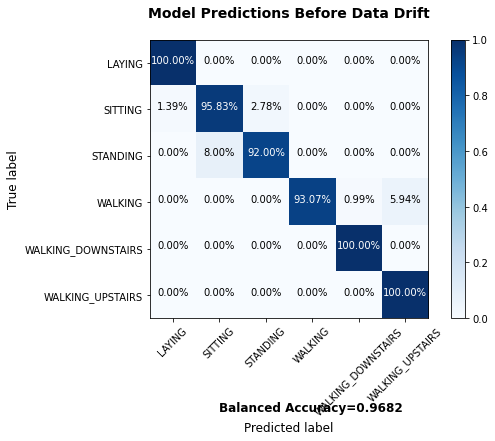

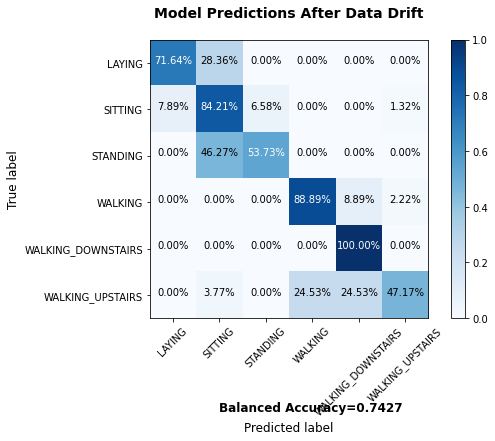

In [9]:
cf1 = normalize_matrix(cm)
cf2 = normalize_matrix(cm2)
plot_confusion_matrix(cf1, label_mapping, cmap='Blues', title='Model Predictions Before Data Drift\n', save=True)
plot_confusion_matrix(cf2, label_mapping, cmap='Blues', title='Model Predictions After Data Drift\n', save=True)